In [12]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import math

#### Christian-Albrechts-Universität zu Kiel --  Institut für Informatik -- Marine Data Science

#### WiSe 2024/25 Lecture: Data Science

|Prof. Dr. Kevin Köser | kk@informatik.uni-kiel.de |
|:--:|:--:|
   
<h1 style="text-align: center;">Network Embedding</h1>

## Global Path Planning

*Graph-search algorithms like Dijkstra or A∗ can be used to plan paths in graphs from a start to a goal. If the cells of a grid map are represented as vertices of a graph with edges between the neighboring cells, graph-search algorithms can be used for  robot path planning. For this exercise sheet we consider the 8-neighborhood of a cell $<x, y>$, which is defined as the set of cells that are adjacent to $<x, y>$ either horizontally, vertically or diagonally.*

*You can find an implementation of graph-based 2D path planning-framework at the end this notebook. Complete the missing pieces following the instructions below.*

## Dijkstra Algorithm

The Dijkstra algorithm can be used to calculate minimum cost paths in a graph. During search, it always chooses the vertex from the graph with the lowest cost from the start and adds its neighboring vertices to the search graph.

- Let M $(x, y)$ denote an occupancy grid map. During search, the grid cells are connected to their neighboring cells to construct the search graph. The function get_neighborhood takes the coordinates of a cell and returns a n × 2 vector with the cell coordinates of its neighbors, considering the boundaries of the map.

In [13]:
def get_neighborhood(cell, occ_map_shape):
  '''
  Arguments:
  cell -- cell coordinates as [x, y]
  occ_map_shape -- shape of the occupancy map (nx, ny)

  Output:
  neighbors -- list of up to eight neighbor coordinate tuples [(x1, y1), (x2, y2), ...]
  '''

  neighbors = []  

  for i in [-1, 0, 1]:
    for j in [-1, 0, 1]:
      x = cell[0] + i
      y = cell[1] + j
      if x < 0 or x >= occ_map_shape[0]: continue
      if y < 0 or y >= occ_map_shape[1]: continue
      if i == 0 and j == 0: continue
      neighbors.append((x, y))


  return neighbors

- get_edge_cost formulates a function for the edge costs between two cells that allows for planning of the shortest collision free path on the grid. It include occupancy information to prefer cells with low occupancy probability over cells with higher probability. We regard a cell as an obstacle if its occupancy probability exceeds a threshold of 0.5.

In [14]:
def get_edge_cost(parent, child, occ_map):
  '''
  Calculate cost for moving from parent to child.

  Arguments:
  parent, child -- cell coordinates as [x, y]
  occ_map -- occupancy probability map

  Output:
  edge_cost -- calculated cost
  '''
  
  edge_cost = 0  

  occ = occ_map[child[0], child[1]]
  if occ >= .5:
    return np.inf
  edge_cost = np.linalg.norm(parent - child)

  return edge_cost + 10 * occ

- The update step of the Dijkstra algorithm in run_path_planning. For the current parent node, we consider all of its neighbors and calculate their tentative distances from the start location (cost) and their predecessor in the grid. You are now ready to run the Dijkstra algorithm within the planning_framework.*

In [15]:
def update_step(x, y, costs, predecessors, parent, occ_map):
    '''
    In-place update of costs of predecessors for neighbours

    Arguments:
    x,y -- cell coordinates of child node
    costs -- costs[x,y] is the minimum currently know distance to cell at (x,y)
    parent -- cell coordinates as [x, y]
    predecessors -- predecessors[x,y] is the predecessors to cell at (x,y) on the best known path
    occ_map -- occupancy probability map
    
    Output:
    

    '''
    neighbors = get_neighborhood(parent, occ_map.shape)
    for child in neighbors:
        child_cost = costs[x, y] + get_edge_cost(parent, child, occ_map)
        if child_cost < costs[child]:
            costs[child] = child_cost
            predecessors[child] = parent
            


## Exercise: Reference Point Embedding

*The A∗ algorithm employs a heuristic to perform an informed search with higher efficiency than the Dijkstra algorithm.*

- **(a)** *Define a heuristic for optimal 2D mobile robot path planning. Complete the function $get\_heuristic$ in the planning framework. The function takes the coordinates of a cell and the goal and returns the estimated costs to the goal. You are now ready to run the A∗ algorithm with the planning_framework.*

The Euclidean distance gives a lower bound for the cost and therefore is a good heuristic. It is equivalent to the actual cost in case of a straight path along cells with zero cost.

- **(b)** *What happens if you inflate your heuristic by using $h2$ , which is a multiple of your defined heuristic h? Try different multiples: $h2 = {1, 2, 5, 10} · h$*

### Answer:

- **(c)** Implement the reference-based graph embedding by filling in the stub of the function `calculate_embedding`.  
  - This function should compute embeddings for the graph nodes using the reference-node based approach.

- **(d)** Fill in the stub function `calculate_network_distance_estimations`.  
  - This function should compute a lower bound of the network distance between nodes, utilizing the embedding generated in **Task (c)**.



In [ ]:
def get_heuristic(cell, goal, embedding = None):
    '''
    Estimate cost for moving from cell to goal based on heuristic.
    Arguments:
    cell, goal -- cell coordinates as [x, y]
    embedding -- optional. Pass the reference node embedding if network distance based estimation is to be applied
    Output:
    cost -- estimated cost
    '''

    def calculate_network_distance_estimations(embedding, cell, goal):
        #########################################
        #  task (d)
        #########################################
        return 0

    heuristic = 0
    h2 = 1

    # network distance based
    if embedding is not None:
        heuristic = h2 * calculate_network_distance_estimations(embedding, cell, goal)
    
    # linear distance based
    else:
        #########################################
        x1, y1 = cell
        x2, y2 = goal
        #heuristic = ((x1-x2)**2 + (y1-y2)**2)**0.5          # multiplier 1
        #heuristic = (((x1- x2)**2 + (y1-y2)**2)**0.5)*2     # multiplier 2
        #heuristic = (((x1- x2)**2 + (y1-y2)**2)**0.5)*4     # multiplier 4
        #heuristic = (((x1- x2)**2 + (y1-y2)**2)**0.5)*5     # multiplier 5
        heuristic = (((x1- x2)**2 + (y1-y2)**2)**0.5)*10     # multiplier 10

        '''
        With larger multipliers the algorithm gets significantly faster at a cost
        of accuracy - the computed path might not be the most efficient.
        '''
        #########################################
        pass

    return heuristic

In [17]:
def calculate_embedding(no_of_reference_nodes, occ_map):
  
  def shortest_path(ref_node, occ_map):
    # cost values for each cell, filled incrementally. 
    # Initialize with infinity
    costs = np.ones(occ_map.shape) * np.inf
    
    # cells that have already been visited
    closed_flags = np.zeros(occ_map.shape)
    
    # store predecessors for each visited cell 
    predecessors = -np.ones(occ_map.shape + (2,), dtype=int)

    # start search
    parent = ref_node
    costs[ref_node[0], ref_node[1]] = 0

    # loop until goal is found
    while True:
      
      # costs of candidate cells for expansion (i.e. not in the closed list)
      open_costs = np.where(closed_flags==1, np.inf, costs)

      # find cell with minimum cost in the open list
      x, y = np.unravel_index(open_costs.argmin(), open_costs.shape)
      
      # break loop if minimal costs are infinite (no open cells anymore)
      if open_costs[x, y] == np.inf:
        break
      
      # set as parent and put it in closed list
      parent = np.array([x, y])
      closed_flags[x, y] = 1
      
      # update costs and predecessor for neighbors
      update_step(x, y, costs, predecessors, parent, occ_map)
    
    return costs
  
    #choose n random reference points
  

  #########################################
  #  task (c)
  #########################################

  #inaccessible cells should not be reference points
  
  
  return 0

# Path Planning Framework

In [ ]:
def plot_map(occ_map, start, goal):

  plt.imshow(occ_map.T, cmap=plt.cm.gray, interpolation='none', origin='upper')
  plt.plot([start[0]], [start[1]], 'ro')
  plt.plot([goal[0]], [goal[1]], 'go')
  plt.axis([0, occ_map.shape[0]-1, 0, occ_map.shape[1]-1])
  plt.xlabel('x')
  plt.ylabel('y')

def plot_expanded(expanded, occ_map, start, goal, clear=True):
  
  if np.array_equal(expanded, start) or np.array_equal(expanded, goal):
    return
  
  plot_map(occ_map, start, goal)
  idx = expanded.nonzero()

  plt.plot(idx[0], idx[1], 'yo')
  #plt.show()
  plt.plot([start[0]], [start[1]], 'ro')
  plt.plot([goal[0]], [goal[1]], 'go')
  if clear:
    display.clear_output(wait=True)
    plt.pause(1e-8)

def plot_path(expanded, occ_map, path, start, goal):

  if np.array_equal(path, goal):
    return
  
  plot_map(occ_map, start, goal)
  plot_expanded(expanded, occ_map, start, goal, False)
  x = [xy[0] for xy in path]
  y = [xy[1] for xy in path]
  plt.plot(x, y, 'bo')
  plt.plot([goal[0]], [goal[1]], 'go')

  display.clear_output(wait=True)
  plt.pause(.01)

def plot_costs(cost):
  plt.figure()
  plt.title("Cost")
  plt.imshow(cost.T, cmap=plt.cm.gray, interpolation='none', origin='upper')
  plt.axis([0, cost.shape[0]-1, 0, cost.shape[1]-1])
  plt.xlabel('x')
  plt.ylabel('y')


def run_path_planning(occ_map, start, goal, h2_multiplier = 1, use_heuristic=None):
  '''
  This implements the
  - A* algorithm using linear distance (in case heuristic is "linear_distance")
  - A* algorithm using reference node based network distance (in case heuristic is "network_based")
  - Dikstra algorithm (in case heuristic is none of the above)
  '''
 
  plot_map(occ_map, start, goal)

  # cost values for each cell, filled incrementally. 
  # Initialize with infinity
  costs = np.ones(occ_map.shape) * np.inf
  
  # cells that have already been visited
  closed_flags = np.zeros(occ_map.shape)
  
  # store predecessors for each visited cell 
  predecessors = -np.ones(occ_map.shape + (2,), dtype=int)

  
  # heuristic for A*
  heuristic = np.zeros(occ_map.shape)

  # linear distance heuristic
  if use_heuristic == "linear_distance":
    for x in range(occ_map.shape[0]):
      for y in range(occ_map.shape[1]):
        heuristic[x, y] = get_heuristic([x, y], goal)
  
  # network distance heuristic usding reference nodes
  elif use_heuristic == "network_based":
    no_of_reference_nodes = 10
    embedding = calculate_embedding(no_of_reference_nodes, occ_map)
    for x in range(occ_map.shape[0]):
      for y in range(occ_map.shape[1]):
        heuristic[x, y] = get_heuristic([x, y], goal, embedding)

  #Dijkstra - no heuristic
  else:
    pass

  # start search
  parent = start
  costs[start[0], start[1]] = 0

  # loop until goal is found
  while not np.array_equal(parent, goal):
    
    # costs of candidate cells for expansion (i.e. not in the closed list)
    open_costs = np.where(closed_flags==1, np.inf, costs) + heuristic

    # find cell with minimum cost in the open list
    x, y = np.unravel_index(open_costs.argmin(), open_costs.shape)
    
    # break loop if minimal costs are infinite (no open cells anymore)
    if open_costs[x, y] == np.inf:
      break
    
    # set as parent and put it in closed list
    parent = np.array([x, y])
    closed_flags[x, y] = 1
    
    # update costs and predecessor for neighbors
    update_step(x, y, costs, predecessors, parent, occ_map)

    #visualize grid cells that have been expanded
    plot_expanded(closed_flags, occ_map, start, goal)
  
  # rewind the path from goal to start (at start predecessor is [-1,-1])
  if np.array_equal(parent, goal):
    path_length = 0
    path = []
    while predecessors[parent[0], parent[1]][0] >= 0:

      predecessor = predecessors[parent[0], parent[1]]
      path_length += np.linalg.norm(parent - predecessor)
      path.append(parent)
      parent = predecessor

      plot_path(closed_flags, occ_map, path, start, goal)

    print ("found goal     : " + str(parent) )
    print ("cells expanded : " + str(np.count_nonzero(closed_flags)) )
    print ("path cost      : " + str(costs[goal[0], goal[1]]) )
    print ("path length    : " + str(path_length) )
  else:
    print ("no valid path found")

  #plot the costs 
  plot_costs(costs)

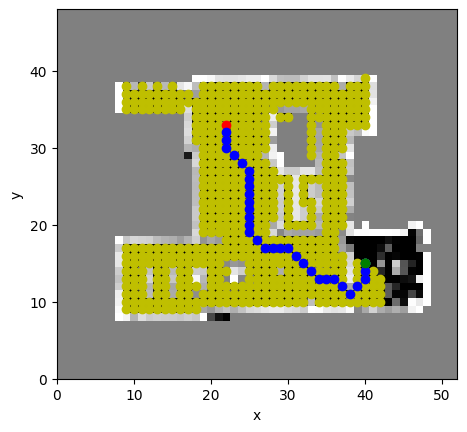

found goal     : [22 33]
cells expanded : 605
path cost      : 36.948820168213054
path length    : 36.38477631085024


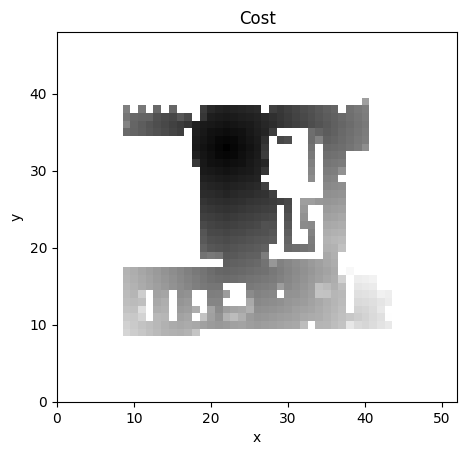

In [19]:
#run Dijkstra

# load the occupancy map
occ_map = np.loadtxt('map.txt')

# start and goal position [x, y]
start = np.array([22, 33])
goal = np.array([40, 15])

run_path_planning(occ_map, start, goal)#, use_heuristic="linear_distance")

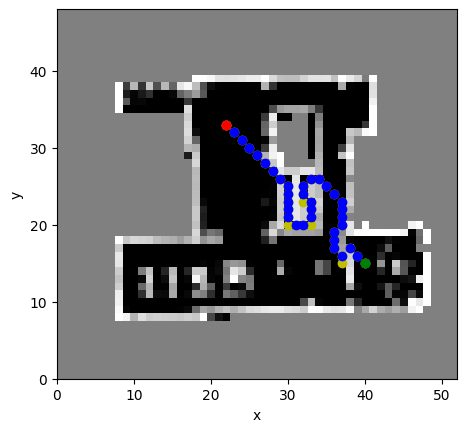

found goal     : [22 33]
cells expanded : 39
path cost      : 57.33219203765201
path length    : 42.28427124746189


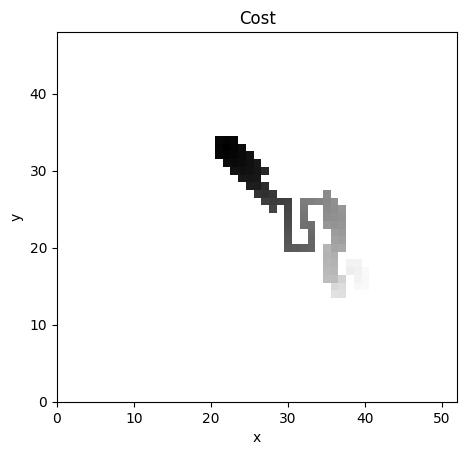

In [23]:
#run A* with linear distance heuristic
run_path_planning(occ_map, start, goal, use_heuristic="linear_distance")

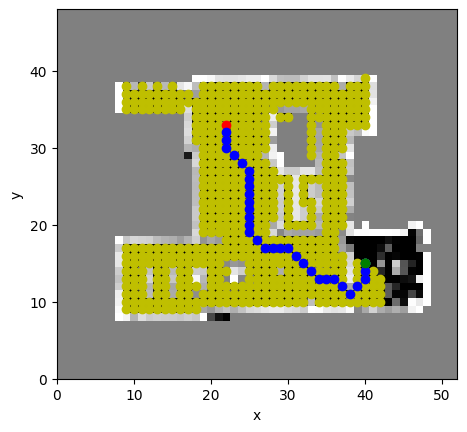

found goal     : [22 33]
cells expanded : 605
path cost      : 36.948820168213054
path length    : 36.38477631085024


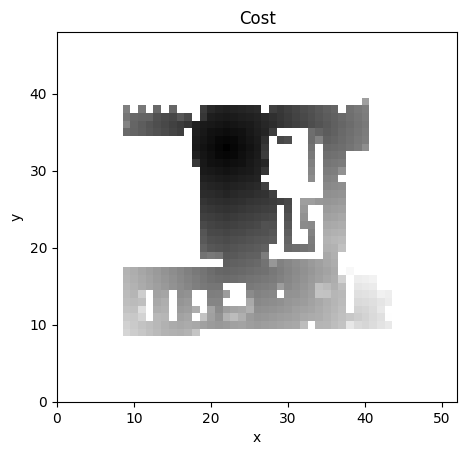

In [21]:
#run A* with network distance based heuristic
run_path_planning(occ_map, start, goal, use_heuristic="network_based")